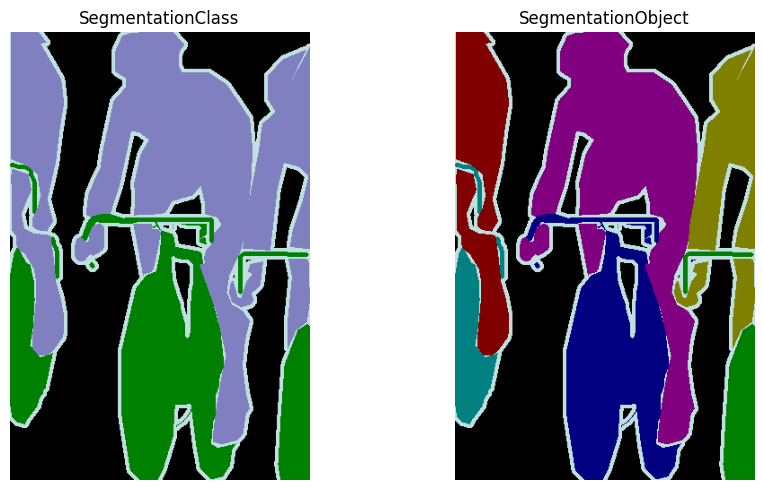

In [2]:
import torch
import cv2
import matplotlib.pyplot as plt
from torch.jit import annotate

root = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/"
filename = "2007_000129"

class_filename = root + 'SegmentationClass/' + filename + '.png'
object_filename = root + 'SegmentationObject/' + filename + '.png'

class_image = cv2.imread(class_filename)
object_image = cv2.imread(object_filename)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(class_image)
plt.title("SegmentationClass")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(object_image)
plt.title("SegmentationObject")
plt.axis("off")

plt.tight_layout()
plt.show()

In [3]:
print(class_image.shape)
print(object_image.shape)

(500, 334, 3)
(500, 334, 3)


In [4]:
import xml.etree.ElementTree as ET
import xmltodict

root = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/"
train_val = open(root + "ImageSets/Main/trainval.txt", "r").read().split("\n")[:-1]
xml_list = []
for i in range(len(train_val[:15])):
    f = ET.parse(root + "Annotations/" + train_val[i] + ".xml").getroot()
    f = xmltodict.parse(ET.tostring(f))
    xml_list.append(f)
xml_list

[{'annotation': {'folder': 'VOC2012',
   'filename': '2008_000002.jpg',
   'source': {'database': 'The VOC2008 Database',
    'annotation': 'PASCAL VOC2008',
    'image': 'flickr'},
   'size': {'width': '500', 'height': '375', 'depth': '3'},
   'segmented': '0',
   'object': {'name': 'tvmonitor',
    'pose': 'Frontal',
    'truncated': '0',
    'occluded': '0',
    'bndbox': {'xmin': '34', 'ymin': '11', 'xmax': '448', 'ymax': '293'},
    'difficult': '0'}}},
 {'annotation': {'folder': 'VOC2012',
   'filename': '2008_000003.jpg',
   'source': {'database': 'The VOC2008 Database',
    'annotation': 'PASCAL VOC2008',
    'image': 'flickr'},
   'size': {'width': '500', 'height': '333', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'train',
     'pose': 'Unspecified',
     'truncated': '1',
     'occluded': '0',
     'bndbox': {'xmin': '46', 'ymin': '11', 'xmax': '500', 'ymax': '333'},
     'difficult': '0'},
    {'name': 'person',
     'pose': 'Right',
     'truncated': '1',
  

In [22]:
xml_list[2]['annotation']

{'folder': 'VOC2012',
 'filename': '2008_000007.jpg',
 'source': {'database': 'The VOC2008 Database',
  'annotation': 'PASCAL VOC2008',
  'image': 'flickr'},
 'size': {'width': '500', 'height': '375', 'depth': '3'},
 'segmented': '0',
 'object': {'name': 'boat',
  'pose': 'Right',
  'truncated': '1',
  'occluded': '0',
  'bndbox': {'xmin': '1', 'ymin': '230', 'xmax': '428', 'ymax': '293'},
  'difficult': '0'}}

In [21]:
xml_list[2]['annotation']['object']

{'name': 'boat',
 'pose': 'Right',
 'truncated': '1',
 'occluded': '0',
 'bndbox': {'xmin': '1', 'ymin': '230', 'xmax': '428', 'ymax': '293'},
 'difficult': '0'}

In [5]:
import os
from PIL import Image
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.models.segmentation as models
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

IMAGE_SIZE = 224
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, split='train', transform=None):
        self.root = root
        self.split = split
        self.transform = transform

        with open(os.path.join(root, 'ImageSets/Segmentation', f'{split}.txt')) as f:
            self.ids = [line.strip() for line in f]

        self.img_dir = os.path.join(root, 'JPEGImages')
        self.mask_dir = os.path.join(root, 'SegmentationClass')

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        img_path = os.path.join(self.img_dir, f"{name}.jpg")
        mask_path = os.path.join(self.mask_dir, f"{name}.png")

        image = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path)
        mask = mask.resize((IMAGE_SIZE, IMAGE_SIZE), resample=Image.NEAREST)
        mask = torch.as_tensor(np.array(mask), dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, mask

In [6]:
transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor()
])
#일관성 유지	학습/평가 이미지 크기가 다르면 모델이 generalize하기 어려움

train_dataset = VOCDataset("VOCtrainval_11-May-2012/VOCdevkit/VOC2012", split='pbl_train', transform=transform)
val_dataset   = VOCDataset("VOCtrainval_11-May-2012/VOCdevkit/VOC2012", split='pbl_val', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=2)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = models.deeplabv3_resnet50(pretrained=True, num_classes=21)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


cuda


In [9]:
class SegMetrics():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.confusion_matrix = np.zeros((num_classes, num_classes))

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_classes, self.num_classes))

    def update(self, preds, labels):
        for pred, label in zip(preds, labels):
            pred = torch.argmax(torch.nn.functional.softmax(pred, dim=0), dim=0).cpu().detach().flatten().numpy()
            label = label.flatten().cpu().detach().numpy()

            mask = (label >= 0) & (label < self.num_classes)
            category = np.bincount(
                label[mask] * self.num_classes + pred[mask]
                , minlength=self.num_classes ** 2
            ).reshape(self.num_classes, self.num_classes)
            self.confusion_matrix += category

    def get_result(self):
        conf_mat = self.confusion_matrix
        pa = np.diag(conf_mat).sum() / (conf_mat.sum() + 1e-7)
        iou = np.diag(conf_mat) / (conf_mat.sum(axis=1) + conf_mat.sum(axis=0) - np.diag(conf_mat) + 1e-7)
        miou = np.nanmean(iou)

        return pa, miou


In [10]:
def train(model, train_loader, criterion, optimizer, device, num_classes):
    model.train()
    total_loss = 0
    metric = SegMetrics(num_classes=num_classes)
    metric.reset()

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        metric.update(outputs.detach().cpu(), masks.detach().cpu())

    pa, miou = metric.get_result()
    return total_loss, pa, miou

In [11]:
def val(model, val_loader, device, num_classes):
    model.eval()
    metric = SegMetrics(num_classes=num_classes)
    metric.reset()

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            metric.update(outputs.cpu(), masks.cpu())

    pa, miou = metric.get_result()
    return pa, miou

In [12]:
for epoch in range(100):
    train_loss, train_pa, train_miou = train(model, train_loader, criterion, optimizer, device, num_classes=21)
    val_pa, val_miou = val(model, val_loader, device, num_classes=21)

    print(f"[Epoch {epoch}] "
          f"Train Loss: {train_loss:.4f} | Train PA: {train_pa:.4f}, mIoU: {train_miou:.4f} | "
          f"Val PA: {val_pa:.4f}, mIoU: {val_miou:.4f}")

[Epoch 0] Train Loss: 441.1550 | Train PA: 0.7580, mIoU: 0.1581 | Val PA: 0.8167, mIoU: 0.3318
[Epoch 1] Train Loss: 231.8908 | Train PA: 0.8425, mIoU: 0.3219 | Val PA: 0.8441, mIoU: 0.4223
[Epoch 2] Train Loss: 173.2225 | Train PA: 0.8740, mIoU: 0.4368 | Val PA: 0.7989, mIoU: 0.3953
[Epoch 3] Train Loss: 137.7470 | Train PA: 0.8968, mIoU: 0.5290 | Val PA: 0.8009, mIoU: 0.4654
[Epoch 4] Train Loss: 114.6674 | Train PA: 0.9151, mIoU: 0.6065 | Val PA: 0.8746, mIoU: 0.5148
[Epoch 5] Train Loss: 95.1496 | Train PA: 0.9277, mIoU: 0.6584 | Val PA: 0.8576, mIoU: 0.4868
[Epoch 6] Train Loss: 81.5325 | Train PA: 0.9378, mIoU: 0.7118 | Val PA: 0.8385, mIoU: 0.4488
[Epoch 7] Train Loss: 79.4993 | Train PA: 0.9393, mIoU: 0.7157 | Val PA: 0.8445, mIoU: 0.4954
[Epoch 8] Train Loss: 67.2610 | Train PA: 0.9471, mIoU: 0.7483 | Val PA: 0.8688, mIoU: 0.5074
[Epoch 9] Train Loss: 56.0976 | Train PA: 0.9556, mIoU: 0.7874 | Val PA: 0.8779, mIoU: 0.5385
[Epoch 10] Train Loss: 49.4740 | Train PA: 0.9612, mIoU

[ 0 17]


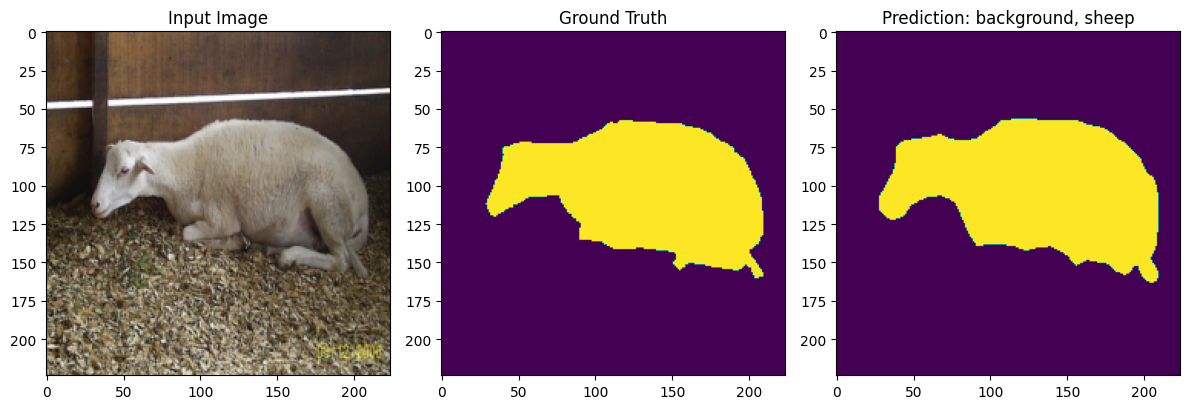

In [18]:
VOC_CLASSES = [
    "background", "airplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair",
    "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

model.eval()
with torch.no_grad():
    img, mask = val_dataset[20]
    mask = np.array(mask)
    mask[mask == 255] = 0
    output = model(img.unsqueeze(0).to(device))['out']
    pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    pred_classes = np.unique(pred)
    print(pred_classes)
    pred_names = [VOC_CLASSES[c] for c in pred_classes]
    class_str = ', '.join(pred_names)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred)
plt.title(f"Prediction: {class_str}")

plt.tight_layout()
plt.show()